$$ L' = L + \frac{\alpha}{2} ||\mathbf{w}||^2$$

$$ \frac{\partial L'}{\partial \mathbf{w}} = \frac{\partial L}{\partial \mathbf{w}} + \alpha \cdot \mathbf{w} $$

\begin{align}
\mathbf{w}^{i+1}  &= \mathbf{w}^{i} - \frac{\partial L'}{\partial \mathbf{w}} \\
                  &= (1-\alpha)\mathbf{w}^{i} - \frac{\partial L}{\partial \mathbf{w}}
\end{align}

其中$L$为神经网络的损失函数,$L'$为加上正则化项后的损失函数,$\alpha$为学习率,$\mathbf{w}$为权重.
可以看出,在存在正则化项的情况下,优化器的优化相当于沿着梯度的方向进行优化,然后把权重替换为$1-\alpha$倍原来的权重.
整个过程就相当于对权重进行了衰减.一般来说,权重衰减的值可以取得比较小,一般在$10^{-4}$到$10^{-5}$直接.

In [43]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [44]:
n_hidden = 200


def gen_data(num_data=30, x_range=(-1, 1)):
    """数据集"""
    w = 1.5
    tr_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    tr_y = w * tr_x + torch.normal(0, 0.8, size=tr_x.size())
    te_x = torch.linspace(*x_range, num_data).unsqueeze_(1)
    te_y = w * te_x + torch.normal(0, 0.8, size=te_x.size())

    return tr_x, tr_y, te_x, te_y


train_x, train_y, test_x, test_y = gen_data(x_range=(-1, 1))

In [45]:
class MLP(nn.Module):
    def __init__(self, neural_num):
        super(MLP, self).__init__()
        self.linears = nn.Sequential(
            nn.Linear(1, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, neural_num),
            nn.ReLU(inplace=True),
            nn.Linear(neural_num, 1),
        )

    def forward(self, x):
        return self.linears(x)


net_normal = MLP(neural_num=n_hidden)
net_weight_decay = MLP(neural_num=n_hidden)

optim_normal = torch.optim.SGD(net_normal.parameters(), lr=0.02, momentum=0.9)
optim_wdecay = torch.optim.SGD(net_weight_decay.parameters(), lr=0.02, momentum=0.9,
                               weight_decay=1e-2)  # 权重的L2正则化系数,默认为0(支持此参数的优化器有:SGD,Adadelta,Adagrad,Adam,RMSprop)

loss_func = torch.nn.MSELoss()  # 损失函数

writer = SummaryWriter(log_dir='./data/L2', filename_suffix="tb")

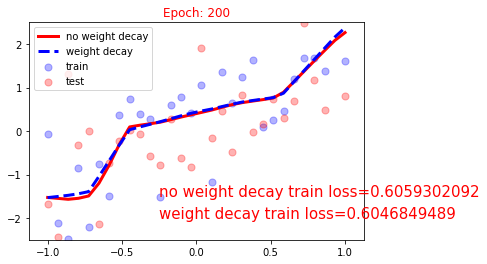

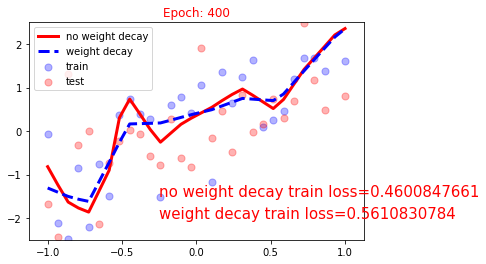

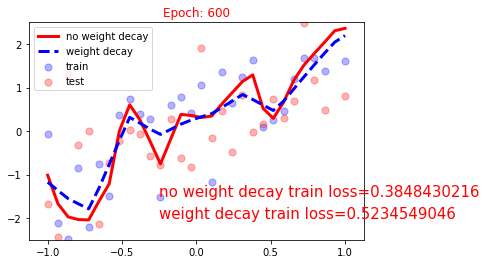

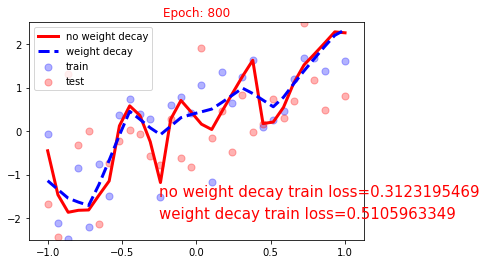

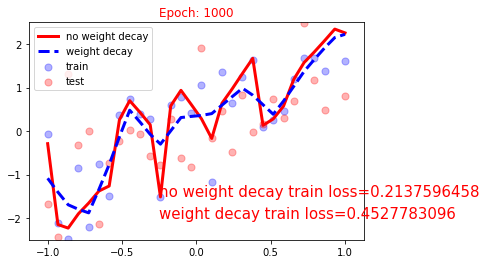

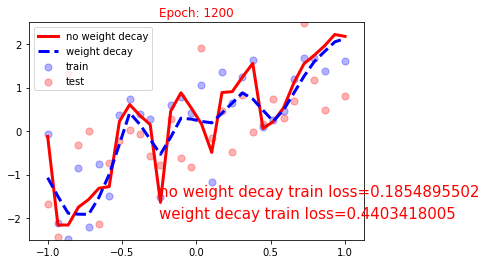

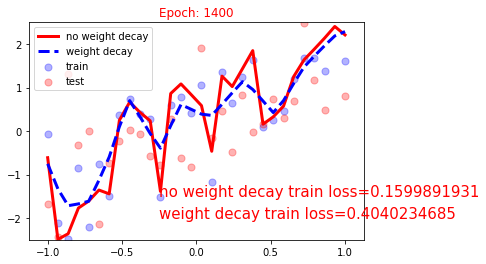

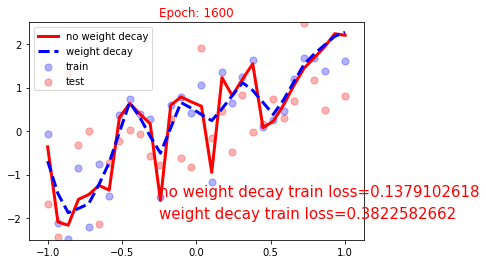

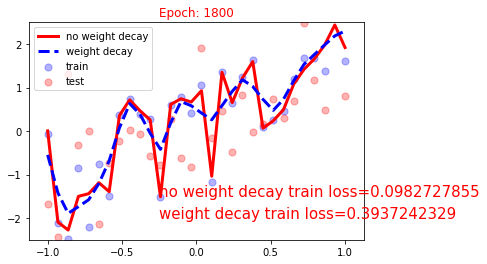

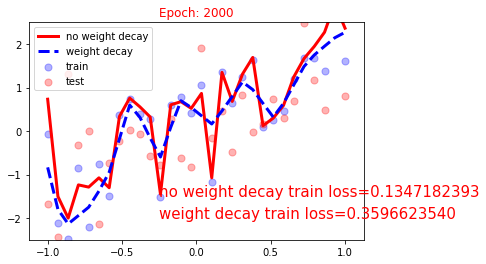

In [46]:
for epoch in range(2000):
    train_pred_normal, train_pred_wdecay = net_normal(train_x), net_weight_decay(train_x)
    train_loss_normal, train_loss_wdecay = loss_func(train_pred_normal, train_y), loss_func(train_pred_wdecay, train_y)

    optim_normal.zero_grad()  # 梯度清零
    optim_wdecay.zero_grad()

    train_loss_normal.backward()  # 反向传播
    train_loss_wdecay.backward()

    optim_normal.step()
    optim_wdecay.step()

    if (epoch + 1) % 200 == 0:
        for name, layer in net_normal.named_parameters():
            writer.add_histogram(name + '_data_normal', layer, epoch)  # 不设定L2正则的权重

        for name, layer in net_weight_decay.named_parameters():
            writer.add_histogram(name + '_data_weight_decay', layer, epoch)  # 设定L2正则的权重(发生了衰减,查看tensorboard易知)

        test_pred_normal, test_pred_wdecay = net_normal(test_x), net_weight_decay(test_x)

        # 由图可知,没有设置L2正则的模型造成了过拟合
        plt.scatter(train_x.data.numpy(), train_y.data.numpy(), c='blue', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='red', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_normal.data.numpy(), 'r-', lw=3, label='no weight decay')
        plt.plot(test_x.data.numpy(), test_pred_wdecay.data.numpy(), 'b--', lw=3, label='weight decay')
        plt.text(-0.25, -1.5, 'no weight decay train loss={:.10f}'.format(train_loss_normal.item()),
                 fontdict={'size': 15, 'color': 'red'})
        plt.text(-0.25, -2, 'weight decay train loss={:.10f}'.format(train_loss_wdecay.item()),
                 fontdict={'size': 15, 'color': 'red'})

        plt.ylim((-2.5, 2.5))
        plt.legend(loc='upper left')
        plt.title("Epoch: {}".format(epoch + 1), color='red')
        plt.show()
        plt.close()


